# Se importan las bibliotecas necesarias

In [1]:
import pandas as pd
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
%matplotlib inline

# Se lee el .csv

In [2]:
train = pd.read_csv('csv/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv('csv/test.csv')

In [5]:
res_w2v = pd.read_csv('csv/solo_embedding.csv')
del res_w2v['Unnamed: 0']
res_w2v.head()

,0
0,0.771458
1,0.606724
2,0.879399
3,0.944014
4,0.894664


In [6]:
res_w2v_test = pd.read_csv('csv/solo_embedding_test.csv')
del res_w2v_test['Unnamed: 0']
res_w2v_test.head()

,0
0,0.869460
1,0.561893
2,0.709307
3,0.601553
4,0.532795


In [7]:
train['res_w2v'] = res_w2v.iloc[:, 0]
train.head()

,id,keyword,location,text,target,res_w2v
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664


In [8]:
test['res_w2v'] = res_w2v_test.iloc[:, 0]
test.tail()

,id,keyword,location,text,res_w2v
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0.628485
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,0.946263
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,0.626327
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,0.805646
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,0.663544


In [9]:
res_elmo = pd.read_csv('csv/elvin_train.csv')
del res_elmo['Unnamed: 0']
res_elmo.head()

,elmo_score
0,0.379383
1,0.585851
2,0.628948
3,0.647089
4,0.677196


In [10]:
train['res_elmo'] = res_w2v.iloc[:, 0]
train.head()

,id,keyword,location,text,target,res_w2v,res_elmo
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,0.606724
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,0.879399
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,0.944014
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,0.894664


In [11]:
res_elmo_test = pd.read_csv('csv/elvin_train.csv')
del res_elmo_test['Unnamed: 0']
res_elmo_test.head()

,elmo_score
0,0.379383
1,0.585851
2,0.628948
3,0.647089
4,0.677196


In [12]:
test['res_elmo'] = res_elmo_test.iloc[:, 0]
test.tail()

,id,keyword,location,text,res_w2v,res_elmo
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0.628485,0.141698
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,0.946263,0.194198
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,0.626327,0.748077
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,0.805646,0.475735
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,0.663544,0.268967


# Elaboración del modelo

Para este modelo se utilizarán árboles de decisión para realizar las predicciones y se tendrán en cuenta los siguientes features extraídos del análisis exploratorio, los cuales fueron seleccionados por el grupo como aquellos que podrían resultan más interesantes:

- Palabras con mayor y menor porcentaje de veracidad.
- Pares de 2 palabras con mayor y menor porcentaje de veracidad.
- Tweets que contienen @, ¿?, ¡! tienden a ser falsos.
- Keywords con mayor y menor porcentaje de veracidad.
- Locaciones más y menos veraces.
- Longitud.

### Preparación del set de datos

#### Parte inicial

In [13]:
#Palabras con mayor y menor porcentaje de veracidad
min_repetitions = ((0.2/100)*len(train.index))
words = train['text'].str.split()
clean_words = []

for sentence in words:
    clean_sentence = []
    for word in sentence:
        clean_word = re.sub('[^A-Za-z0-9]+','', word)
        if(clean_word != ''):
            clean_sentence.append(clean_word.lower())
    clean_words.append(clean_sentence)

In [14]:
train_aux = train
train_aux['words'] = clean_words
train_aux = train_aux.explode('words')
train_aux.head()

,id,keyword,location,text,target,res_w2v,res_elmo,words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,our
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,deeds
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,are
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,the
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,reason


In [15]:
#Palabras con mayor y menor porcentaje de veracidad (TEST, CREO QUE SEPARA LOS TWEETS POR PALABRAS)***********
min_repetitions = ((0.2/100)*len(test.index))
words_test = test['text'].str.split()
clean_words_test = []

for sentence in words_test:
   clean_sentence_test = []
   for word in sentence:
       clean_word_test = re.sub('[^A-Za-z0-9]+','', word)
       if(clean_word_test != ''):
           clean_sentence_test.append(clean_word_test.lower())
   clean_words_test.append(clean_sentence_test)

test['words'] = clean_words_test
test.head()

,id,keyword,location,text,res_w2v,res_elmo,words
0,0,NaN,NaN,Just happened a terrible car crash,0.869460,0.379383,"[just, happened, a, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.561893,0.585851,"[heard, about, earthquake, is, different, citi..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.709307,0.628948,"[there, is, a, forest, fire, at, spot, pond, g..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.601553,0.647089,"[apocalypse, lighting, spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.532795,0.677196,"[typhoon, soudelor, kills, 28, in, china, and,..."


In [16]:
train_aux = train_aux.groupby('words').agg({'target':['sum','count']})
train_aux = train_aux[train_aux['target']['count']>min_repetitions]
train_aux['veracity'] = train_aux['target']['sum']/train_aux['target']['count']
train_aux.head()

target        veracity
         sum count          
words                       
0          9    12  0.750000
05        14    18  0.777778
06         7    10  0.700000
1         29    64  0.453125
10         9    23  0.391304

In [17]:
train_aux.reset_index(inplace=True) 

In [18]:
#Pares de 2 palabras con mayor y menor porcentaje de veracidad.
train_aux2 = train
train_aux2['words'] = clean_words
words_pairs = []

for sentence in train_aux2['words']:
    pairs = []
    for i in range(len(sentence)-1):
        pairs.append(sentence[i] + ' ' + sentence[i+1])
    words_pairs.append(pairs)
    
train_aux2['words'] = words_pairs
train_aux2 = train_aux2.explode('words')
train_aux2.head()

,id,keyword,location,text,target,res_w2v,res_elmo,words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,our deeds
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,deeds are
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,are the
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,the reason
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,reason of


In [19]:
train_aux2 = train_aux2.groupby('words').agg({'target':['sum','count']})
train_aux2 = train_aux2[train_aux2['target']['count']>min_repetitions]
train_aux2['veracity'] = train_aux2['target']['sum']/train_aux2['target']['count']

In [20]:
#las palabras que son '' la cagan
train_aux2.head(10)

target        veracity
                  sum count          
words                                
05 at              13    13  1.000000
11yearold boy      20    20  1.000000
12000 nigerian     11    12  0.916667
15 in              13    13  1.000000
16yr old           28    28  1.000000
2 spos              9     9  1.000000
3 words             0     8  0.000000
30 fires            7     7  1.000000
300w curved         1     7  0.142857
320 ir              0     7  0.000000

In [21]:
train_aux2.reset_index(inplace=True)

In [22]:
# Keywords más y menos veraces
train_aux3 = train
train_aux3 = train_aux3.groupby('keyword').agg({'target':['sum','count']})
train_aux3 = train_aux3[train_aux3['target']['count']>min_repetitions]
train_aux3['veracity'] = train_aux3['target']['sum']/train_aux3['target']['count']
train_aux3.head()

target        veracity
                       sum count          
keyword                                   
ablaze                  13    36  0.361111
accident                24    35  0.685714
aftershock               0    34  0.000000
airplane%20accident     30    35  0.857143
ambulance               20    38  0.526316

In [23]:
train_aux3.reset_index(inplace=True)

In [24]:
# Locaciones más y menos veraces
train_aux4 = train
train_aux4 = train_aux4.groupby('location').agg({'target':['sum','count']})
train_aux4 = train_aux4[train_aux4['target']['count']>min_repetitions]
train_aux4['veracity'] = train_aux4['target']['sum']/train_aux4['target']['count']
train_aux4.head()

target        veracity
               sum count          
location                          
304              0     9  0.000000
Atlanta, GA      5    10  0.500000
Austin, TX       3     7  0.428571
Australia        9    18  0.500000
California       7    17  0.411765

In [25]:
train_aux4.reset_index(inplace=True)

#### Parte final

In [26]:
top_words = train_aux[train_aux['veracity']>0.9]['words']
worst_words = train_aux[train_aux['veracity']<0.1]['words']

In [27]:
top_words_pairs = train_aux2[train_aux2['veracity']>0.9]['words']
worst_words_pairs = train_aux2[train_aux2['veracity']<0.1]['words']

In [28]:
top_keywords = train_aux3[train_aux3['veracity']>0.9]['keyword']
worst_keywords = train_aux3[train_aux3['veracity']<0.1]['keyword']

In [29]:
top_locations = train_aux4[train_aux4['veracity']>0.9]['location']
worst_locations = train_aux4[train_aux4['veracity']<0.1]['location']

In [30]:
train = train.drop(columns='words')
train['long(char)'] = train['text'].str.len()

aux = []
for i in words:
    aux.append(len(i))

train['long(word)'] = aux
train.head()

,id,keyword,location,text,target,res_w2v,res_elmo,long(char),long(word)
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,0.606724,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,0.879399,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,0.944014,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,0.894664,88,16


In [31]:
test = test.drop(columns='words')

In [32]:
test['long(char)'] = test['text'].str.len()

aux = []

for i in words_test:
    aux.append(len(i))

test['long(word)'] = aux
test.head()

,id,keyword,location,text,res_w2v,res_elmo,long(char),long(word)
0,0,NaN,NaN,Just happened a terrible car crash,0.869460,0.379383,34,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.561893,0.585851,64,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.709307,0.628948,96,19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.601553,0.647089,40,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.532795,0.677196,45,8


In [33]:
def count_text_ocurrences(texts, words):
    ocurrences = []
    for text in texts:
        count = 0
        for word in words:
            if word in text:
                count = count+1
        ocurrences.append(count)
    return ocurrences

def count_ocurrences(searched, series):
    ocurrences = []
    for element in searched:
        count = 0
        if element in series:
            count = count+1
        ocurrences.append(count)
    return ocurrences

def contains_char(texts, char1, char2=''):
    ocurrences = []
    for text in texts:
        count = 0
        if char1 in text:
            count = 1
        if (count==0)&(char2!=''):
            if char2 in text:
                count = 1
        ocurrences.append(count)
    return ocurrences

In [34]:
train['top_words'] = count_text_ocurrences(train['text'], top_words)
train['worst_words'] = count_text_ocurrences(train['text'], worst_words)
train['top_words_pairs'] = count_text_ocurrences(train['text'], top_words_pairs)
train['worst_words_pairs'] = count_text_ocurrences(train['text'], worst_words_pairs)
train.head()

,id,keyword,location,text,target,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,69,13,1,1,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,0.606724,38,7,1,1,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,0.879399,133,22,4,1,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,0.944014,65,8,2,1,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,0.894664,88,16,2,1,0,0


In [35]:
test['top_words'] = count_text_ocurrences(test['text'], top_words)
test['worst_words'] = count_text_ocurrences(test['text'], worst_words)
test['top_words_pairs'] = count_text_ocurrences(test['text'], top_words_pairs)
test['worst_words_pairs'] = count_text_ocurrences(test['text'], worst_words_pairs)
test.head()

,id,keyword,location,text,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs
0,0,NaN,NaN,Just happened a terrible car crash,0.869460,0.379383,34,6,3,0,0,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.561893,0.585851,64,9,1,2,0,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.709307,0.628948,96,19,1,1,0,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.601553,0.647089,40,4,2,1,0,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.532795,0.677196,45,8,1,0,0,0


In [36]:
train['top_keywords'] = count_ocurrences(train['keyword'], top_keywords)
train['worst_keywords'] = count_ocurrences(train['keyword'], worst_keywords)
train['top_locations'] = count_ocurrences(train['location'], top_locations)
train['worst_locations'] = count_ocurrences(train['location'], worst_locations)
train.head()

,id,keyword,location,text,target,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,69,13,1,1,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,0.606724,38,7,1,1,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,0.879399,133,22,4,1,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,0.944014,65,8,2,1,1,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,0.894664,88,16,2,1,0,0,0,0,0,0


In [37]:
test['top_keywords'] = count_ocurrences(test['keyword'], top_keywords)
test['worst_keywords'] = count_ocurrences(test['keyword'], worst_keywords)
test['top_locations'] = count_ocurrences(test['location'], top_locations)
test['worst_locations'] = count_ocurrences(test['location'], worst_locations)
test.head()

,id,keyword,location,text,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations
0,0,NaN,NaN,Just happened a terrible car crash,0.869460,0.379383,34,6,3,0,0,0,0,0,0,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.561893,0.585851,64,9,1,2,0,0,0,0,0,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.709307,0.628948,96,19,1,1,0,0,0,0,0,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.601553,0.647089,40,4,2,1,0,0,0,0,0,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.532795,0.677196,45,8,1,0,0,0,0,0,0,0


In [38]:
train['arroba'] = contains_char(train['text'],'@')
train['singnosDeInterrogacion'] = contains_char(train['text'],'\?', '¿')
train['signosDeExclamacion'] = contains_char(train['text'],'!','¡')
train.head()

,id,keyword,location,text,target,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,arroba,singnosDeInterrogacion,signosDeExclamacion
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,0.771458,69,13,1,1,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,0.606724,38,7,1,1,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,0.879399,133,22,4,1,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,0.944014,65,8,2,1,1,0,0,0,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,0.894664,88,16,2,1,0,0,0,0,0,0,0,0,0


In [39]:
test['arroba'] = contains_char(test['text'],'@')
test['singnosDeInterrogacion'] = contains_char(test['text'],'\?', '¿')
test['signosDeExclamacion'] = contains_char(test['text'],'!','¡')
test.head()

,id,keyword,location,text,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,arroba,singnosDeInterrogacion,signosDeExclamacion
0,0,NaN,NaN,Just happened a terrible car crash,0.869460,0.379383,34,6,3,0,0,0,0,0,0,0,0,0,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.561893,0.585851,64,9,1,2,0,0,0,0,0,0,0,0,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.709307,0.628948,96,19,1,1,0,0,0,0,0,0,0,0,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.601553,0.647089,40,4,2,1,0,0,0,0,0,0,0,0,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.532795,0.677196,45,8,1,0,0,0,0,0,0,0,0,0,0


In [40]:
train = train.drop(columns=['keyword','location','text'])
train = train.set_index('id')
train.head(20)

,target,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,arroba,singnosDeInterrogacion,signosDeExclamacion
id,,,,,,,,,,,,,,,,
1,1,0.771458,0.771458,69,13,1,1,0,0,0,0,0,0,0,0,0
4,1,0.606724,0.606724,38,7,1,1,0,0,0,0,0,0,0,0,0
5,1,0.879399,0.879399,133,22,4,1,0,0,0,0,0,0,0,0,0
6,1,0.944014,0.944014,65,8,2,1,1,0,0,0,0,0,0,0,0
7,1,0.894664,0.894664,88,16,2,1,0,0,0,0,0,0,0,0,0
8,1,0.952795,0.952795,110,18,2,2,0,0,0,0,0,0,0,0,0
10,1,0.973386,0.973386,95,14,3,1,0,0,0,0,0,0,0,0,0
13,1,0.550996,0.550996,59,15,0,1,1,0,0,0,0,0,0,0,0
14,1,0.713014,0.713014,79,12,1,1,0,0,0,0,0,0,0,0,0


In [41]:
test = test.drop(columns=['keyword','location','text'])
test = test.set_index('id')
test.head(20)

,res_w2v,res_elmo,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,arroba,singnosDeInterrogacion,signosDeExclamacion
id,,,,,,,,,,,,,,,
0,0.869460,0.379383,34,6,3,0,0,0,0,0,0,0,0,0,0
2,0.561893,0.585851,64,9,1,2,0,0,0,0,0,0,0,0,0
3,0.709307,0.628948,96,19,1,1,0,0,0,0,0,0,0,0,0
9,0.601553,0.647089,40,4,2,1,0,0,0,0,0,0,0,0,0
11,0.532795,0.677196,45,8,1,0,0,0,0,0,0,0,0,0,0
12,0.677602,0.717489,34,4,2,2,0,0,0,0,0,0,0,0,0
21,0.058321,0.900621,72,12,1,1,0,0,0,0,0,0,0,0,0
22,0.129282,0.386334,17,4,1,0,0,0,0,0,0,0,0,0,1
27,0.198659,0.709198,16,4,0,1,0,0,0,0,0,0,0,0,0


In [42]:
col_rename = {'long(char)': 'longEnChars', 'long(word)': 'longEnWords', 'top_words': 'topWords', 'worst_words': 'worstWords', 'top_words_pairs': 'topWordsPairs',  
             'worst_words_pairs': 'worstWordsPairs', 'top_keywords': 'topKeywords', 'worst_keywords': 'worstKeywords', 'top_locations': 'topLocations', 
             'worst_locations': 'worstLocations'}
train = train.rename(columns= col_rename)
train.head()

,target,res_w2v,res_elmo,longEnChars,longEnWords,topWords,worstWords,topWordsPairs,worstWordsPairs,topKeywords,worstKeywords,topLocations,worstLocations,arroba,singnosDeInterrogacion,signosDeExclamacion
id,,,,,,,,,,,,,,,,
1,1,0.771458,0.771458,69,13,1,1,0,0,0,0,0,0,0,0,0
4,1,0.606724,0.606724,38,7,1,1,0,0,0,0,0,0,0,0,0
5,1,0.879399,0.879399,133,22,4,1,0,0,0,0,0,0,0,0,0
6,1,0.944014,0.944014,65,8,2,1,1,0,0,0,0,0,0,0,0
7,1,0.894664,0.894664,88,16,2,1,0,0,0,0,0,0,0,0,0


In [43]:
col_rename = {'long(char)': 'longEnChars', 'long(word)': 'longEnWords', 'top_words': 'topWords', 'worst_words': 'worstWords', 'top_words_pairs': 'topWordsPairs',  
             'worst_words_pairs': 'worstWordsPairs', 'top_keywords': 'topKeywords', 'worst_keywords': 'worstKeywords', 'top_locations': 'topLocations', 
             'worst_locations': 'worstLocations'}
test = test.rename(columns= col_rename)
test.head()

,res_w2v,res_elmo,longEnChars,longEnWords,topWords,worstWords,topWordsPairs,worstWordsPairs,topKeywords,worstKeywords,topLocations,worstLocations,arroba,singnosDeInterrogacion,signosDeExclamacion
id,,,,,,,,,,,,,,,
0,0.869460,0.379383,34,6,3,0,0,0,0,0,0,0,0,0,0
2,0.561893,0.585851,64,9,1,2,0,0,0,0,0,0,0,0,0
3,0.709307,0.628948,96,19,1,1,0,0,0,0,0,0,0,0,0
9,0.601553,0.647089,40,4,2,1,0,0,0,0,0,0,0,0,0
11,0.532795,0.677196,45,8,1,0,0,0,0,0,0,0,0,0,0


### Entrenamiento del set de datos

In [44]:
X, y = train.iloc[:,train.columns != 'target'], train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=478)
X.head()

,res_w2v,res_elmo,longEnChars,longEnWords,topWords,worstWords,topWordsPairs,worstWordsPairs,topKeywords,worstKeywords,topLocations,worstLocations,arroba,singnosDeInterrogacion,signosDeExclamacion
id,,,,,,,,,,,,,,,
1,0.771458,0.771458,69,13,1,1,0,0,0,0,0,0,0,0,0
4,0.606724,0.606724,38,7,1,1,0,0,0,0,0,0,0,0,0
5,0.879399,0.879399,133,22,4,1,0,0,0,0,0,0,0,0,0
6,0.944014,0.944014,65,8,2,1,1,0,0,0,0,0,0,0,0
7,0.894664,0.894664,88,16,2,1,0,0,0,0,0,0,0,0,0


#### XGBoost

In [45]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 20, alpha = 10, n_estimators = 5)

In [46]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [47]:
preds = xg_reg.predict(X_test)

Accuracy Score : 0.9553415061295972
Precision Score : 0.9637526652452025
Recall Score : 0.9300411522633745
F1 Score : 0.9465968586387435


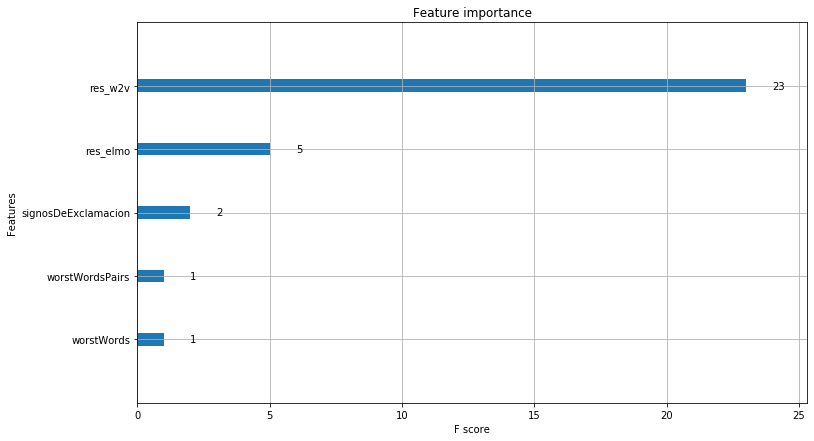

In [48]:
print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

In [50]:
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(xgb.XGBClassifier(objective ='binary:logistic'), {
        'colsample_bytree': np.linspace(0,1,11),
        'n_estimators': range(1, 20)
    }, 
    cv=50, 
    return_train_score=False, 
    n_iter=50
)
rs.fit(X,y)
hiperparametros = pd.DataFrame(rs.cv_results_)[['param_colsample_bytree','param_n_estimators','mean_test_score']]
maximo = hiperparametros['mean_test_score'].max()
hiperparametros[hiperparametros['mean_test_score'] == maximo]

,param_colsample_bytree,param_n_estimators,mean_test_score
29,0.2,8,0.946791


In [ ]:
maximo = hiperparametros['mean_test_score'].max()
hiperparametros[hiperparametros['mean_test_score'] == maximo]

In [ ]:
hiperparametros.sort_values('mean_test_score', ascending=False)

In [ ]:
#from sklearn.model_selection import cross_val_score
#xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
#                colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 20, alpha = 10, n_estimators = 5)
#A = cross_val_score(xg_reg, X, y ,cv=35, scoring= 'accuracy')
#A = pd.Series(A)
#A.mean()

In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/xgboost.csv')
# df.head()

In [ ]:
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.2, 0.3, 0.4],
#         'max_depth': [10, 15, 20]
#         }
# grid_acc = GridSearchCV(xg_reg, param_grid = params)
# grid_acc.fit(X_train, y_train)
# y_pred_acc = grid_acc.predict(X_test)

# # New Model Evaluation metrics 
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc.round())))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc.round())))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc.round())))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_acc.round())))

#### RandomForest

In [ ]:
rf_model = RandomForestRegressor(random_state=30, n_estimators=5, max_depth=10)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

In [ ]:
rf_model.feature_importances_
plt.figure(figsize=(30,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/randomForest.csv')
# df.head()

rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

#### LightGBM

In [ ]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# params = {
#      'objective': 'regression',
#      'metric': 'rmse',
#      'num_leaves': 5,
#      'learning_rate': 0.1,
#      'feature_fraction': 0.9,
#  }

# params = {
#      'objective': 'regression',
#  }

# gbm = lgb.train(params,
#                  lgb_train,
#                  num_boost_round=100,
#                  valid_sets=lgb_eval,
#                  early_stopping_rounds=10)

# preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
# print('Precision Score : ' + str(precision_score(y_test,preds.round())))
# print('Recall Score : ' + str(recall_score(y_test,preds.round())))
# print('F1 Score : ' + str(f1_score(y_test,preds.round())))
# rmse = np.sqrt(mean_squared_error(y_test, preds))
# print("RMSE: %f" % (rmse))

In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/lightgbm.csv')
# df.head()

#### CatBoost

In [ ]:
# model = CatBoostRegressor()
# model.fit(X_train, y_train)
# preds = model.predict(X_test)

# print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
# print('Precision Score : ' + str(precision_score(y_test,preds.round())))
# print('Recall Score : ' + str(recall_score(y_test,preds.round())))
# print('F1 Score : ' + str(f1_score(y_test,preds.round())))

In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/catboost.csv')
# df.head()

In [ ]:
# model = LogisticRegression()
# model.fit(X_train, y_train)
# preds = model.predict(X_test)

# print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
# print('Precision Score : ' + str(precision_score(y_test,preds.round())))
# print('Recall Score : ' + str(recall_score(y_test,preds.round())))
# print('F1 Score : ' + str(f1_score(y_test,preds.round())))

In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/logicRegression.csv')
# df.head()

In [ ]:
# xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
#                 colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 20, alpha = 10, n_estimators = 80)
# rf_model = RandomForestRegressor(random_state=13, n_estimators=80, max_depth=20)

# eclf2 = VotingRegressor(estimators=[
#          ('xgb', xg_reg), ('rf', rf_model)])

In [ ]:
# eclf2 = eclf2.fit(X, y)

In [ ]:
# preds = eclf2.predict(X_test)

# print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
# print('Precision Score : ' + str(precision_score(y_test,preds.round())))
# print('Recall Score : ' + str(recall_score(y_test,preds.round())))
# print('F1 Score : ' + str(f1_score(y_test,preds.round())))

### Predicciones

In [ ]:
test.head()

In [ ]:
#predigo con el modelo entrenago con cross validation
a = test.iloc[:,:]
a = xgb.DMatrix(a)
preds = model.predict(a)

In [ ]:
final = test['arroba'].to_frame()
final['target'] = preds.round().astype(int)
final.drop(columns=['arroba'], inplace=True)
final.head()

In [ ]:
final.to_csv('csv/submission_modelo_7.csv')

In [ ]:
anterior = pd.read_csv('csv/submission_modelo5_voting(1).csv')
nueva = pd.read_csv('csv/submission_modelo_7.csv')

In [ ]:
print(len(nueva.index))
diferencias = np.absolute(anterior['target']-nueva['target'])
a = sum(diferencias)
a